In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/YOA

/content/drive/MyDrive/YOA


In [ ]:
import pandas as pd

lin28b_bed = pd.read_csv('LIN28B_K562_eCLIP.bed', sep='\t', header=None)
ddx3x_bed = pd.read_csv('DDX3X_K562_eCLIP.bed', sep='\t', header=None)

# 컬럼 이름 지정 (narrowPeak 포맷 기준)
columns = [
    'chr', 'start', 'end', 'name', 'score', 'strand',
    'signalValue', 'pValue', 'qValue', 'peak'
]
lin28b_bed.columns = columns
ddx3x_bed.columns = columns

# 파일 미리보기
print('LIN28B:')
print(lin28b_bed.head())
print('\nDDX3X:')
print(ddx3x_bed.head())

LIN28B:
     chr      start        end             name  score strand  signalValue  \
0  chr10   72275308   72275328  LIN28B_K562_IDR   1000      +     6.337501   
1   chr9  130854159  130854233  LIN28B_K562_IDR   1000      +     3.611149   
2   chr9  130854233  130854238  LIN28B_K562_IDR   1000      +     3.581694   
3   chr2  169821941  169822020  LIN28B_K562_IDR   1000      -     3.474968   
4   chr2  135866620  135866664  LIN28B_K562_IDR   1000      -     5.177964   

      pValue  qValue  peak  
0  41.608210      -1    -1  
1   8.904796      -1    -1  
2   3.686923      -1    -1  
3   4.305029      -1    -1  
4   7.830121      -1    -1  

DDX3X:
     chr      start        end            name  score strand  signalValue  \
0  chr11   94973496   94973570  DDX3X_K562_IDR   1000      -     3.466426   
1  chr22   40819227   40819349  DDX3X_K562_IDR   1000      -     3.318698   
2  chr22   40819194   40819227  DDX3X_K562_IDR   1000      -     3.073488   
3   chrX   63351168   63351323  D

In [ ]:
%cd /content/drive/MyDrive/YOA

/content/drive/MyDrive/YOA


In [ ]:
import pandas as pd


# 2. GTF 불러오기
gtf = pd.read_csv("gencode.v38.annotation.gtf", sep="\t", comment="#", header=None,
                  names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])

# 3. UTR/ CDS만 추출
utr = gtf[gtf["feature"] == "UTR"].copy()
cds = gtf[gtf["feature"] == "CDS"].copy()

# 4. transcript_id 추출 함수
def extract_transcript_id(attr):
    for entry in attr.split(";"):
        if "transcript_id" in entry:
            return entry.split('"')[1]
    return None

utr["transcript_id"] = utr["attribute"].apply(extract_transcript_id)
cds["transcript_id"] = cds["attribute"].apply(extract_transcript_id)

# 5. CDS 시작/끝 좌표 집계
cds_range = cds.groupby("transcript_id")[["start", "end"]].agg(["min", "max"])
cds_range.columns = ['start_min', 'start_max', 'end_min', 'end_max']
cds_range["cds_start"] = cds_range[["start_min", "end_min"]].min(axis=1)
cds_range["cds_end"] = cds_range[["start_max", "end_max"]].max(axis=1)
cds_range = cds_range[["cds_start", "cds_end"]]

# 6. UTR에 merge
utr = utr.merge(cds_range, on="transcript_id", how="left")

# 7. strand, CDS 위치 기반 5'/3' 구분 함수
def label_utr(row):
    if pd.isna(row["cds_start"]) or pd.isna(row["cds_end"]):
        return "unknown"
    if row["strand"] == "+":
        return "5UTR" if row["end"] < row["cds_start"] else "3UTR"
    else:
        return "3UTR" if row["start"] > row["cds_end"] else "5UTR"

utr["UTR_type"] = utr.apply(label_utr, axis=1)

# 8. BED 포맷 저장
utr_bed = utr[["chr", "start", "end", "transcript_id", "score", "strand", "UTR_type"]]
utr_bed.to_csv("/content/annotated_UTRs_v38.bed", sep="\t", index=False, header=False)


In [ ]:
!head /content/annotated_UTRs_v38.bed


chr1	65419	65433	ENST00000641515.2	.	+	5UTR
chr1	65520	65564	ENST00000641515.2	.	+	5UTR
chr1	70006	71585	ENST00000641515.2	.	+	3UTR
chr1	450740	450742	ENST00000426406.4	.	-	5UTR
chr1	685679	685718	ENST00000332831.4	.	-	5UTR
chr1	686655	686673	ENST00000332831.4	.	-	3UTR
chr1	923923	924431	ENST00000616016.5	.	+	5UTR
chr1	944151	944574	ENST00000616016.5	.	+	3UTR
chr1	923923	924431	ENST00000618323.5	.	+	5UTR
chr1	944151	944574	ENST00000618323.5	.	+	3UTR


In [ ]:
%cd /content/drive/MyDrive/YOA

/content/drive/MyDrive/YOA


In [ ]:
!awk '$7=="5UTR"' /content/annotated_UTRs_v38.bed > five_utr.bed
!awk '$7=="3UTR"' /content/annotated_UTRs_v38.bed > three_utr.bed


In [ ]:
!apt-get update
!apt-get install -y bedtools



Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
#LIN28B
# 5'UTR
!bedtools intersect -a LIN28B_K562_eCLIP.bed -b five_utr.bed -u | wc -l
# 3'UTR
!bedtools intersect -a LIN28B_K562_eCLIP.bed -b three_utr.bed -u | wc -l
# CDS
!bedtools intersect -a LIN28B_K562_eCLIP.bed -b CDS.bed -u | wc -l

#DDX3X
# 5'UTR
!bedtools intersect -a DDX3X_K562_eCLIP.bed -b five_utr.bed -u | wc -l
# 3'UTR
!bedtools intersect -a DDX3X_K562_eCLIP.bed -b three_utr.bed -u | wc -l
# CDS
!bedtools intersect -a DDX3X_K562_eCLIP.bed -b CDS.bed -u | wc -l

1870
1891
4684
2808
2722
3831


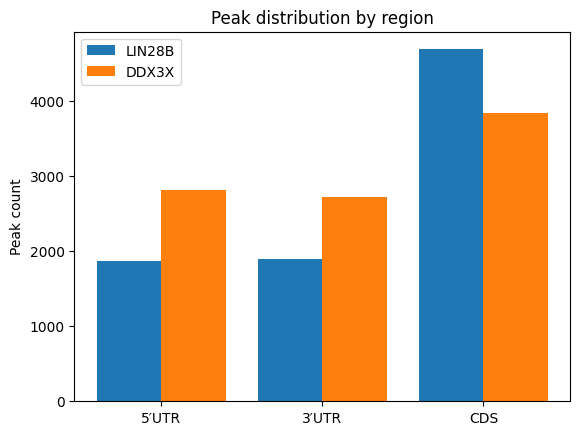

In [ ]:
import matplotlib.pyplot as plt

# (위 표의 결과를 여기에 직접 입력!)
labels = ['5′UTR', '3′UTR', 'CDS']
LIN28B_counts = [1870, 1891, 4684]
DDX3X_counts = [2808, 2722, 3831]

x = range(len(labels))
plt.bar(x, LIN28B_counts, width=0.4, label='LIN28B', align='center')
plt.bar([i+0.4 for i in x], DDX3X_counts, width=0.4, label='DDX3X', align='center')
plt.xticks([i+0.2 for i in x], labels)
plt.ylabel('Peak count')
plt.title('Peak distribution by region')
plt.legend()
plt.show()
